In [2]:
# For display purposes
from IPython.core.display import HTML
table_css = 'table {display: inline-block} '
HTML('<style>{}</style>'.format(table_css))

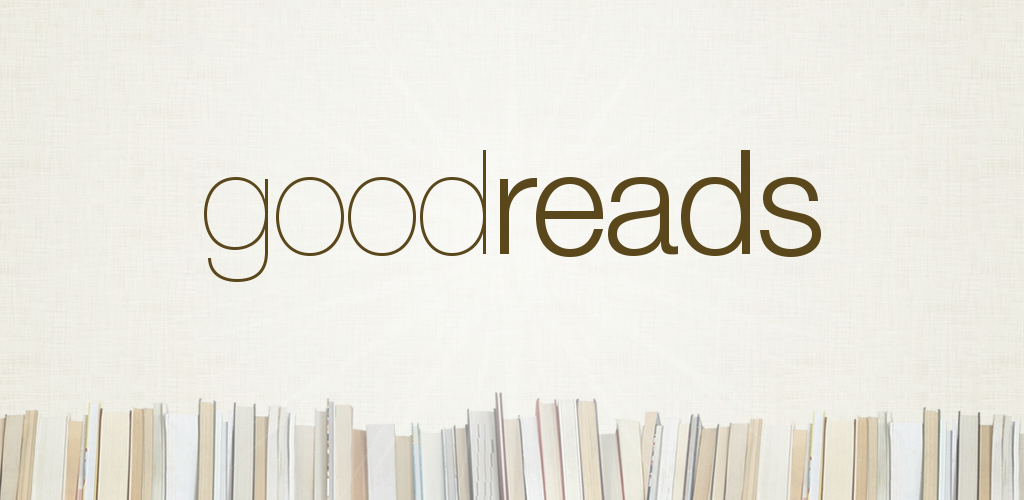

# Goodreads Book Analysis

Goodsreads is a social media platform dedicated to the sharing and rating of books. The website contains a large database of books and associated details including titles, authors and publishers along with quotations and reviews from users. 

The basic goal of this project is to use this vast dataset to explore how different attributes relate and contribute to the popularity of a book. With a huge number of possible relationships to investigate, with focus on just a few here such as:

    - What are the highest rated books and what makes them so?
    
    - Who are the most prolific and most popular authors and how do their ratings vary over time?
    
    - Do attributes of a book such as the number of pages or the month it was published correlate with how much 
        they are read or how highly they are rated?


# Table of contents
1. [Dataset](#dataset)
2. [Loading the dataset and modules](#loading)
3. [Data Cleaning](#cleaning)
    1. [Removing empty values](#empty)
    2. [Publication Date](#cleaning-pubdate)
4. [Data Analysis](#analysis)
    1. [What are the highest rated books?](#highest-rated)
    2. [Which authors have the most books?](#authors)
    3. [How does the average rating change with publication year?](#num_ratings_vs_year)
    4. [Who are the best authors?](#best-authors)
        1. [Which author has the highest average rating?](#highest-rated-authors)
        2. [Which author has been rated the most often?](#most-rated-authors)
    5. [How does the average rating relate to the number of pages?](#num-pages-vs-rating)
    6. [How does the average rating relate to the number of reviews?](#num-reviews-vs-rating)
    7. [Conclusions](#conclusions)



# Dataset <a name="dataset"> </a>

The raw data used here is obtained using a dedicated web scraping tool developed for this project: 
<a href="https://github.com/EmmaKLofthouse/goodreads_scraper">goodreads_scraper</a>. 

This provides the following variables for each book:



| Column             | Description                         |
|  ----------------  |   :-------  |
| title              | The book title                      |
| Number of pages    | Number of pages in the book         |
| Language           | Language of text                    |
| Author             | Author's Name                       |
| Rating Value       | Average rating. From 0 to 5         |
| Rating Count       | Total number of ratings             |
| Review Count       | Total number of written reviews     |
| ISBN               | International Standard Book Number  |                       
| Publication Date   | Date of publication                 |     



# Load the dataset and required modules 
<a name="loading"></a>


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

First, we read in the JSON file containing data on all the scraped books and convert it to a pandas dataframe for easy manipulation

In [4]:
def read_json_to_dataframe(json_file_path):
    # Read JSON data into a pandas DataFrame
    df = pd.read_json(json_file_path, orient='records')
    return df

df = read_json_to_dataframe('goodreads_data.json')

# Data Cleaning <a name="cleaning"></a>

The data obtained from the web scraper is raw uncleaned data and is likely to include some problematic values. So, our first step is to clean and organise the dataset. 

In [5]:
df.head()

,Title,Number of Pages,Language,Author,Rating Value,Rating Count,Review Count,ISBN,Publication Date
0,Lottery Master Guide: Turn a Game of Chance In...,192,English,Gail Howard,3.98,46,4,9780945760382,"First published April 1, 1997"
1,Winning Lotto / Lottery For Everyday Players,160,English,Professor Jones,2.5,6,1,9781580420471,"First published November 1, 1993"
2,Lottery Winners&apos; Guide: When It Happens T...,128,English,Shayne Jones,2.94,16,1,9780976867371,"First published January 25, 2006"
3,Solar Lottery,188,English,Philip K. Dick,3.49,4686,349,9780575074552,"First published January 1, 1955"
4,"The Lucky Lottery (A to Z Mysteries, #12)",86,English,Ron Roy,4.06,3008,105,9780439332934,"First published November 28, 2000"


In [6]:
print(f"The dataset contains {df.shape[0]} books and {df.shape[1]} data columns")

The dataset contains 134394 books and 9 data columns


In [7]:
print(f"The columns in the dataset are: \n{list(df.columns)}")

The columns in the dataset are: 
['Title', 'Number of Pages', 'Language', 'Author', 'Rating Value', 'Rating Count', 'Review Count', 'ISBN', 'Publication Date']


We can drop some of the columns immediately. For example, we are not going to need the ISBN so we can exclude it now.

In [8]:
df.drop(['ISBN'],axis=1,inplace=True)

The remaining columns look useful for our analysis but their names are not very code friendly, so let's update them.

In [9]:
df.rename(columns = {'Title':'title', 'Author':'author', 'Number of Pages':'num_pages', 'Language': 'lang',
                     'Rating Value': 'avg_rating', 'Rating Count': 'num_ratings', 'Review Count': 'num_reviews', 
                     'Publication Date':'pub_date_string'}, inplace=True)
#df.columns

### Duplicate Entries
Next we check the rows and see if there are any duplicates.

In [10]:
duplicate_rows = df[df.duplicated(['title', 'author'])]
print(f"There are {len(duplicate_rows)} entires that are duplicates.")

There are 8825 entires that are duplicates.


A quick look at the first entries shows that these books do indeed appear to be duplicates with the same authors, publications data and the same number of ratings/reviews. Therefore we can delete these duplicated entries

In [11]:
duplicate_rows[:10]

,title,num_pages,lang,author,avg_rating,num_ratings,num_reviews,pub_date_string
17,The Glass Menagerie,116,English,Tennessee Williams,3.73,132332,3555,"First published January 1, 1945"
21,The Glass Menagerie,90,English,Tennessee Williams,3.73,132332,3555,"First published January 1, 1945"
160,The Fellowship of the Ring (The Lord of the Ri...,458,English,J.R.R. Tolkien,4.39,2778429,38098,"First published July 29, 1954"
174,A Separate Reality: Further Conversations with...,318,English,Carlos Castaneda,4.08,18404,351,"First published January 1, 1971"
176,The Razor&apos;s Edge,N/A,English,W. Somerset Maugham,4.19,47621,4090,"First published January 1, 1944"
178,The Razor&apos;s Edge,0,English,W. Somerset Maugham,4.19,47621,4090,"First published January 1, 1944"
185,Italian Hours,310,English,Henry James,3.62,341,37,"First published January 1, 1909"
245,"The Riddle-Master of Hed (Riddle-Master, #1)",229,English,Patricia A. McKillip,3.99,12507,626,"First published January 1, 1976"
247,Fool&apos;s Run,0,English,Patricia A. McKillip,3.66,662,57,"First published January 1, 1987"
249,"Harpist in the Wind (Riddle-Master, #3)",261,English,Patricia A. McKillip,4.18,7546,258,"First published January 1, 1979"


In [12]:
print(f"Before removing duplicate entries there are {df.shape[0]} books.")
df.drop_duplicates(subset=['title', 'author'],inplace=True)
print(f"After removing duplicate entries there are {df.shape[0]} books.")

Before removing duplicate entries there are 134394 books.
After removing duplicate entries there are 125569 books.


### Investigating column values

Let's now have a look at the types of values in the different feature columns

In [13]:
df.describe()

,title,num_pages,lang,author,avg_rating,num_ratings,num_reviews,pub_date_string
count,125569,125569,125569,125569,125569,125569,125569,125569
unique,123245,1605,74,59533,289,15891,4505,10674
top,Selected Poems,0,English,William Shakespeare,N/A,N/A,N/A,"First published January 1, 2006"
freq,34,5230,110123,292,12368,12368,32349,2583


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125569 entries, 0 to 134393
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   title            125569 non-null  object
 1   num_pages        125569 non-null  object
 2   lang             125569 non-null  object
 3   author           125569 non-null  object
 4   avg_rating       125569 non-null  object
 5   num_ratings      125569 non-null  object
 6   num_reviews      125569 non-null  object
 7   pub_date_string  125569 non-null  object
dtypes: object(8)
memory usage: 8.6+ MB


Some quick things to note:

    - 'N/A' values in numeric columns - need to deal with these
    
    - The columns that we expect to be numeric, e.g. avg_rating, num_pages, num_ratings, num_reviews are not.
    
    - Publication date appears to be a string. This would be more useful as a datetime object.

## Removing empty values <a name="empty"></a>

#### Number of pages
How many empty values are there in the 'Number of pages' column?

In [15]:
print(df.num_pages.value_counts())

n0 = df.num_pages.value_counts()[0]
n_NA = df.num_pages.value_counts()['N/A']
percent0 = (n0/df.shape[0])*100
percent_NA = (n_NA/df.shape[0])*100

print(f"\nThere are {n_NA} books with 'N/A' in number of pages ({percent_NA:.1f}% of the total sample).")
print(f"There are also {n0} books which supposedly have 0 pages ({percent0:.1f}% of the total sample). This can't be physical. ")
print("As these are relatively small percentages, we decide to drop these books from the dataset.")

0        5230
N/A      5130
256      2798
192      2578
224      2487
         ... 
1401        1
1398        1
1395        1
1389        1
15564       1
Name: num_pages, Length: 1605, dtype: int64

There are 5130 books with 'N/A' in number of pages (4.1% of the total sample).
There are also 5230 books which supposedly have 0 pages (4.2% of the total sample). This can't be physical. 
As these are relatively small percentages, we decide to drop these books from the dataset.


In [16]:
df = df[df['num_pages']!='N/A']
df = df[df['num_pages']>0]
print(f"The dataset now contains {df.shape[0]} books and {df.shape[1]} data columns")

The dataset now contains 115209 books and 8 data columns


#### Ratings and Reviews

There are also a significant number of 'N/A' values in the ratings and reviews columns. 

In [17]:
rating_value_counts = df.avg_rating.value_counts()
print(rating_value_counts)

n_NA = df.avg_rating.value_counts()['N/A']
percent_NA = (n_NA/df.shape[0])*100

print(f"\nThere are {n_NA} books with 'N/A' in number of ratings ({percent_NA:.1f}% of the total sample).")
print(f"Are there are books with 0 in num_ratings: {0 in rating_value_counts}")

N/A     10879
4        5935
3        2790
5        2695
3.5      1757
        ...  
2.26        1
2.61        1
2.06        1
2.1         1
2.31        1
Name: avg_rating, Length: 287, dtype: int64

There are 10879 books with 'N/A' in number of ratings (9.4% of the total sample).
Are there are books with 0 in num_ratings: False


Upon inspection, we find that the entries with 'N/A' ratings correspond to books with zero ratings. We have two options here: A) convert 'N/A' to 0 or B) drop rows with 'N/A'. Both are valid options but as there are a significant number of these cases and a lot of them appear to be books or documents that haven't been widely published or marketed we believe they could potentially skew our results. Therefore, we choose to remove them

In [18]:
df=df[df.avg_rating != 'N/A']
print(f"There are now {df.shape[0]} entires")

There are now 104330 entires


However, for the number of reviews, we don't want to remove everything with N/A as they may still have ratings but no text reviews. Instead, we do want these entries to be equal to zero.

In [19]:
df['num_reviews'] = df['num_reviews'].replace('N/A', 0).astype(int)

Now that these columns have been cleaned and there are no longer any string elements we can convert the dtypes to integers/floats. 

In [20]:
df.num_pages = df.num_pages.astype(int)
df.avg_rating = df.avg_rating.astype(float)
df.num_ratings = df.num_ratings.astype(int)

## Publication date <a name="cleaning-pubdate"></a>

We can convert the publication date to a datetime object for easy manipulation later.

Our dataset contain books from before the 18th Century. This causes problems when using pd.to_datetime as it has a minimum of 1677-09-21 and a maximum of 2262-04-11.
Our analysis is focused on looking at trends in book publications and ratings over more recent years and is not interested in data from more than 300 years ago where the publications are very sparse. As a result, I make the decision that it is ok to use this simple method to obtain datetime and simply exclude any rows that then result in a 'null' date. 


In [21]:
#Strip off the text at the start of the date
df['pub_date'] = df['pub_date_string'].str.split('ublished').str[-1]

#due to ambiguity, books published in 2-digit years, e.g. 50AD, are mistakenly converted to dates in the 2000s
# We need to remove these first. 
df['year_str'] = df['pub_date'].str.split(', ').str[-1]
df=df[df.year_str.apply(lambda x: len(x)>2)]
df.drop(['year_str'],axis=1,inplace=True)

# The we convert the remaining dates into datetime objects 
df["pub_date"]=pd.to_datetime(df["pub_date"], errors = 'coerce')
df = df[df.pub_date.notnull()]
print(f"The dataset now has {df.shape[0]} books.")

The dataset now has 102946 books.


In [22]:
# We also create new columns for the day, month and years as integers
df['year'] = df.pub_date.dt.year.astype(int)
df['month'] = df.pub_date.dt.month.astype(int)
df['day'] = df.pub_date.dt.day.astype(int)

Now that we have a clean and easy to use dataset we can start doing some analysis!

# Data Analysis <a name="analysis"></a>

We start with a simple heatmap to quickly see if there are any correlations between the variables

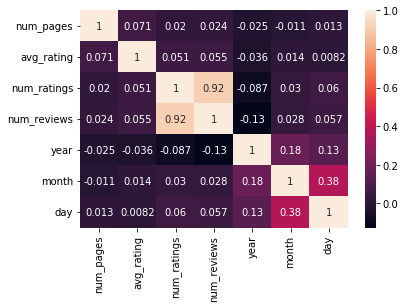

In [23]:
sns.heatmap(df.corr(),annot=True)

It appears that most of the variables are uncorrelated. The only correlations we see are:
 1.   **A strong positive correlation between the number of ratings and the number of reviews.** 
    This is expected as when writing a review on goodreads you are also prompted to give a rating.
    Therefore we expect books with a high number of reviews will also have a high number of ratings as this 
    confirms.
        
        
 2. **A weaker correlation between the publication day and the publication month.**
    This was somewhat less expected. However, further investigation below shows that the most common 
    publication dates are the first of the month and also at the start of the year. Given that '1' is by far 
    the most common value for both variables this produces a positive correlation between the two. 

In [24]:
print("The most common publication months are:")
print(df.month.value_counts()[:5])
print("\nThe most common publication days are:")
print(df.day.value_counts()[:5])

The most common publication months are:
1     52820
10     6247
9      6037
6      4645
4      4579
Name: month, dtype: int64

The most common publication days are:
1     75034
15     2309
30     1872
28     1679
31     1241
Name: day, dtype: int64


Let's do some simple histograms to show distribution of each of the numerical data columns

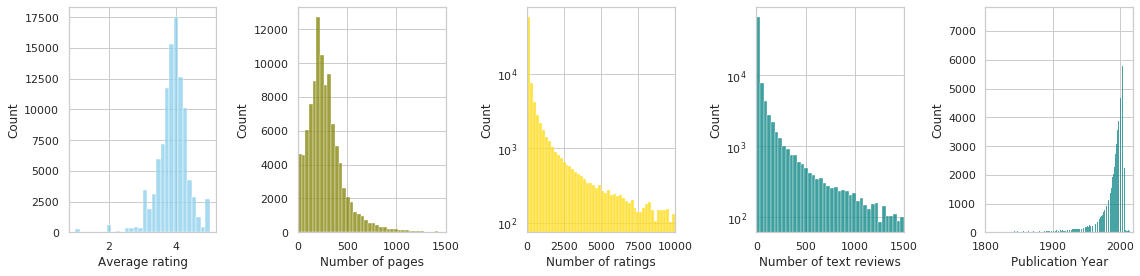

In [25]:
sns.set(style="whitegrid") 
fig,axs = plt.subplots(1,5, figsize = (16,4))
sns.histplot(data=df['avg_rating'], color="skyblue", bins=30,ax=axs[0])
axs[0].set_xlabel("Average rating")

sns.histplot(data=df['num_pages'], color="olive", binrange=(0,1500),bins=40,ax=axs[1])
axs[1].set_xlim(0,1500)
axs[1].set_xlabel('Number of pages')

sns.histplot(data=df['num_ratings'], color="gold", binrange=(0,10000),bins=50,ax=axs[2])
axs[2].set_xlim(0,10000)
axs[2].set_xlabel("Number of ratings")
axs[2].set_yscale("log")

sns.histplot(data=df['num_reviews'], color="teal", binrange=(0,1500),bins=40,ax=axs[3])
axs[3].set_xlim(0,1500)
axs[3].set_xlabel("Number of text reviews")
axs[3].set_yscale("log")

sns.histplot(data=df.year, color="teal",ax=axs[4])
axs[4].set_xlabel("Publication Year")
axs[4].set_xlim(1800,2020)

fig.tight_layout()

### Initial Observations:
    
**Average Rating**: The average rating is strongly clustered around 4 with a close to normal distribution and very few books rated 2 or below

**Number of Pages**: Most books have around 200-300 pages but there is a long tail towards higher values. 

**Number of Reviews and Ratings**: Most books have a low number of ratings and reviews (Note that the yscale here is logarithmic!) with the distribution heavily skewed towards 0 ratings/reviews but there is a long tail towards very popular books which have been rated thousands of times.

**Publication Year**: The dataset mainly consists of books published around the year 2000. Note that we excluded books from before 1677 above, however there are still very few books from this year up to around 1950. In addition, we have few books after 2010, likely because the webscraper worked by starting at bookID 1 and scraping the next ID in succession. More recent books have been added to the database later and hence have larger bookID values. If this was an issue, we could perform the web scraping again but start at higher bookIDs.

## What are the highest rated books? <a name="highest-rated"></a>

In [26]:
top_rated = df.sort_values(by='avg_rating',ascending=False).head(10)
# or: top_rated = df.nlargest(columns="average_rating", n=10)
top_rated[:5]

,title,num_pages,lang,author,avg_rating,num_ratings,num_reviews,pub_date_string,pub_date,year,month,day
90885,Tribe Of The Tiger,260,English,Joe Dacy II,5.0,2,1,"First published January 1, 1997",1997-01-01,1997,1,1
70334,Rainbowfishes : In Nature and In the Aquarium,182,English,Gerald Allen,5.0,1,0,"First published April 1, 1995",1995-04-01,1995,4,1
92777,Salinas Valley (Images of America: California),128,English,Margaret E. Clovis,5.0,2,0,"First published October 31, 2005",2005-10-31,2005,10,31
14963,Hafiz: Tongue of the Hidden: Poems from the Divan,92,English,Hafez,5.0,2,0,"Published January 1, 1990",1990-01-01,1990,1,1
14962,"Hafiz, Master of Persian Poetry: A Critical Bi...",400,English,Parvin Loloi,5.0,1,0,"First published March 4, 2004",2004-03-04,2004,3,4


Therse are all books with very few ratings. What we really want to see is the books which have a decent number of ratings AND which have the highest overall score. 

In [180]:
df_ratings100 = df[df.num_ratings > 100]
top_rated = df_ratings100.sort_values(by='avg_rating',ascending=False).head(15)
#top_rated[:5]

Text(0, 0.5, '')

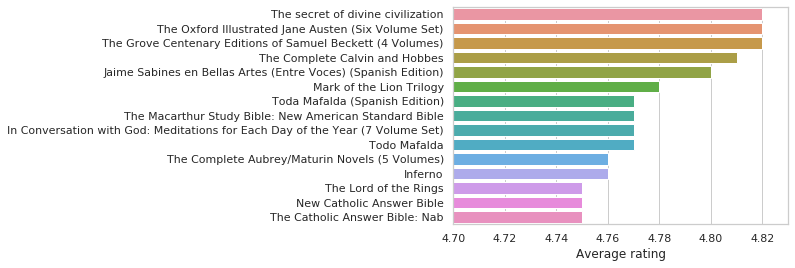

In [28]:
sns.barplot(data=top_rated,x='avg_rating',y='title')
plt.xlim(4.7,4.83)
plt.xlabel("Average rating")
plt.ylabel("")

## Which authors have the most books? <a name="authors"></a>

In [29]:
prolific_authors = df.value_counts("author").head(15)

Text(0.5, 0, 'Number of books')

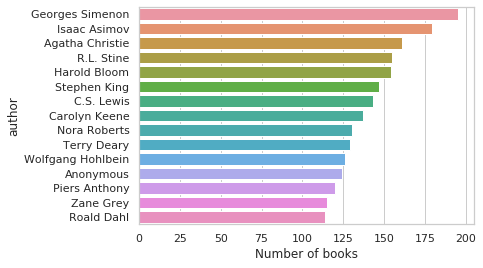

In [30]:
sns.barplot(y=prolific_authors.index, x=prolific_authors)
plt.xlabel("Number of books")

In [31]:
df_copy = df.copy()
df_simenon = df_copy[df_copy.author == "Georges Simenon"]
#df_simenon['decade'] = (df_simenon.year//10)*10

#calculate mean rating over periods of 5 years
df_simenon_rating_year = df_simenon.groupby((df_simenon['year']//5)*5)['avg_rating'].agg(['mean'])

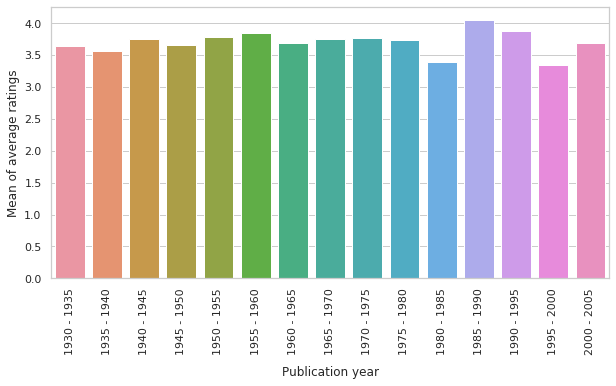

In [32]:
fig,ax = plt.subplots(figsize = (10,5))
sns.barplot(data=df_simenon_rating_year,x=df_simenon_rating_year.index, y="mean",ax=ax)
plt.ylabel("Mean of average ratings")
plt.xlabel("Publication year")
plt.xticks(rotation=90)
years = list(df_simenon_rating_year.index)
labels = [f"  {start} - {end}" for start, end in zip(years, years[1:] + [2005])]
ax.set_xticklabels(labels);

The average rating looks relatively consistent across the years. Is this true for all books by all authors?

## How does the average rating change with publication year?<a name="rating_v_year"></a>

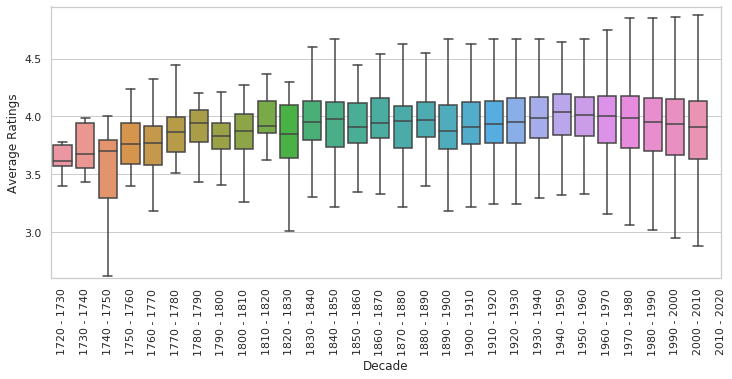

In [203]:
df_box = df[df.year>1720]
df_box = df_box[df_box.year<2010]
bins = range(1720, max(df_box['year'])+10,10)
df_box['year_bins'] = pd.cut(df_box['year'], bins=bins)

plt.figure(figsize=(12, 5))
sns.boxplot(x='year_bins', y='avg_rating', data=df_box, showfliers=False)

# Create a list of custom labels
custom_labels = [f"{int(start)} - {int(start) + 10}" for start in bins]
plt.xticks(range(len(custom_labels)), custom_labels, rotation=90)

plt.xlabel('Decade')
plt.ylabel('Average Ratings')
plt.ylim(2.6,4.95);

While there has been an increase in ratings when looking at more recent books compared to previous centuries, the number of books in these early years is very low. Let's look a bit more closely at how the average ratings have changed over the past 150 years. 

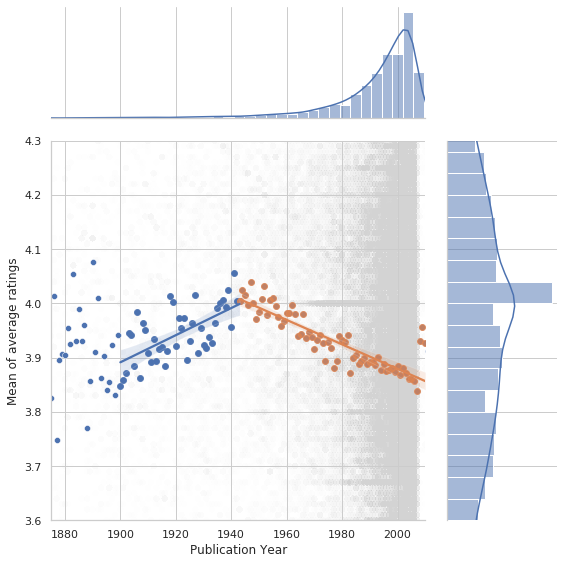

In [38]:
early_years = df[df['year'].between(1900,1943)]
early_ratings = early_years.groupby(early_years['year'])['avg_rating'].agg(['mean'])

modern_years = df[df['year'].between(1943,2010)]
modern_ratings = modern_years.groupby(modern_years['year'])['avg_rating'].agg(['mean'])

p = sns.JointGrid(data=df,x=df.year, y=df.avg_rating,ratio=3,height=8)

all_ = sns.scatterplot(data=df,x=df.year,y=df.avg_rating,alpha=0.01,color='lightgrey', edgecolor = "none", ax=p.ax_joint)

m = sns.scatterplot(data=df_rating_year,x=df_rating_year.index,y='mean',ax=p.ax_joint)


e = sns.regplot(data=early_ratings,x=early_ratings.index,y='mean',ax=p.ax_joint)
m = sns.regplot(data=modern_ratings,x=modern_ratings.index,y='mean',ax=p.ax_joint)

all_.set_xlabel("Publication Year")
all_.set_ylabel("Mean of average ratings")
all_.set_ylim(3.6,4.3)
all_.set_xlim(1875,2010)

sns.histplot(x=df.year,ax=p.ax_marg_x,kde=True,bins=90)
sns.histplot(y=df.avg_rating,ax=p.ax_marg_y,kde=True,bins=100)


Above, we group the books by publication year and plot the mean of the average ratings. Even we just plot this there is clearly some relationship such that the rating generally increases through the first half of the 20th century and then turns over and steadily decreases. 

**Why is there such a clear inflection around 1940-1950??**

There are various things to consider:
1. Are books truly getting worse with time?

2. Is it because as we go back in time, it's likely that only the better/more popular books survived to make it onto goodreads. However this doesn't explain the change from 1900 to ~1945 where the average rating INCREASES as time goes on.

3. When doing analysis, it's important to consider the wider context from which our data is obtained. Was there something else happening at this time? One of the most obvious things in this era is World War 2, but how would this impact books. An intial search does show that this indeed could have had an impact. For example: https://www.writing.ie/guest-blogs/the-1940s-a-time-when-books-mattered/

Another relationship we can look at is the number of ratings. 

## Number of ratings by publication year <a name="num_ratings_vs_year"></a>

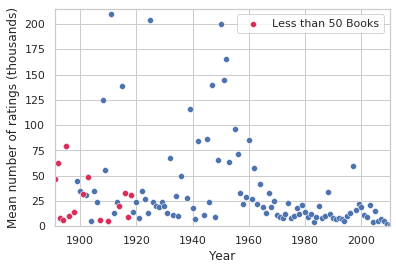

In [206]:
years_less_than_50_books = df['year'].value_counts()[df['year'].value_counts() < 50].index

df_num_ratings_year = (df.groupby((df['year']))['num_ratings'].agg(['mean'])/1000).reset_index()
sns.scatterplot(data=df_num_ratings_year,x=df_num_ratings_year.year,y='mean')

# Highlight years with less than 50 books published
sns.scatterplot(data=df_num_ratings_year[df_num_ratings_year['year'].isin(years_less_than_50_books)],
                x=df_num_ratings_year.year,y='mean', color='#dc2b57', label='Less than 50 Books')

plt.ylim(0,215)
plt.xlim(1891,2010)
plt.xlabel('Year')
plt.ylabel("Mean number of ratings (thousands)");

As with the average rating, we also see here a change in the 1940s-1950s with a much higher average number of ratings. This seems to support the idea that books from this era are generally more popular - they are read/rated more and the rating is generally better!

## Who are the best authors? <a name="best-authors"></a>

Another interesting question is to find out which individual authors are most popular. 
There are multiple possible ways to answer this question. For example, do we consider the author that has the highest average rating? Or how about the author whose books have been rated the most often? Let's explore both of these questions.

### Which author has the highest average rating? <a name="highest-rated-authors"></a>



In [44]:
# Calculate the average rating for each author
avg_rating_by_author = df.groupby('author')['avg_rating'].mean().reset_index()
avg_rating_by_author.columns = ['author', 'author_rating']
avg_rating_by_author['author_rating'] = avg_rating_by_author['author_rating'].round(2)

total_num_ratings_by_author =  df.groupby('author')['num_ratings'].sum().reset_index()
total_num_ratings_by_author.columns = ['author', 'author_num_ratings']

authors = pd.merge(avg_rating_by_author,total_num_ratings_by_author, on='author')

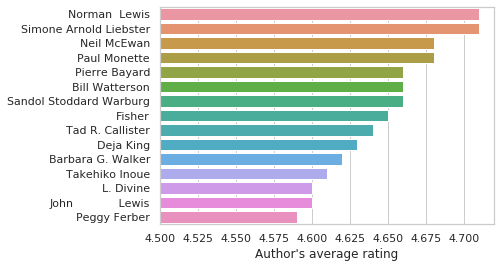

In [45]:
authors_gt_1000_ratings = authors[authors.author_num_ratings > 1000]
highest_rated_authors = authors_gt_1000_ratings.sort_values("author_rating",ascending=False).head(15)
sns.barplot(data=highest_rated_authors,x='author_rating',y='author')

plt.xlim(4.5,4.72)
plt.ylabel("")
plt.xlabel("Author's average rating");

### Which author has been rated the most? <a name="most-rated-authors"></a>



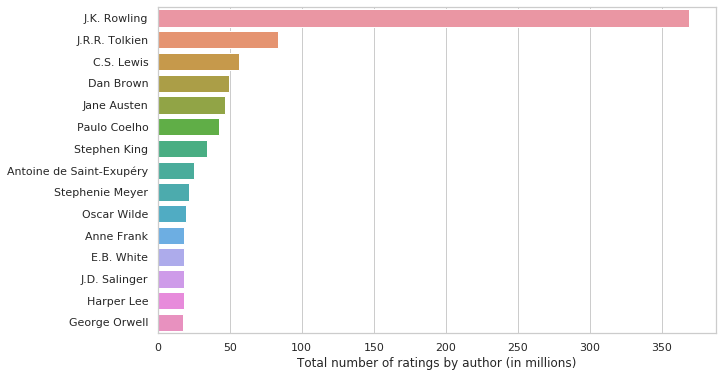

In [204]:
most_rated_authors = authors_gt_1000_ratings.sort_values("author_num_ratings",ascending=False).head(15)

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=most_rated_authors, x='author_num_ratings', y='author')
ax.set_ylabel("")
ax.set_xlabel("Total number of ratings by author (in millions)")

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x / 1e6)))

Interestingly, there is very little overlap in the authors given by these two approaches. The second plot shows the authors who are most popular (i.e. read by more people) and this includes many of the well-known names. In particular J.K. Rowling whose books are by far the most read books on Goodreads with over 350 million ratings. On ther other hand, the names of the highest rated authors are perhaps less well-known but for those who do read their work, they are generally considered better

## Number of pages vs average rating <a name="num-pages-vs-rating"></a>

Text(0, 0.5, 'Average rating')

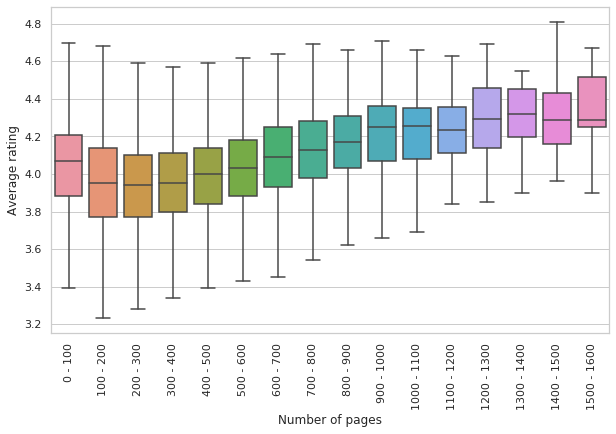

In [225]:
df_ratings_gt1000 = df[df.num_ratings >1000]
df_pages_lt1600 = df_ratings_gt1000[df_ratings_gt1000.num_pages<1600]

bins = range(0, max(df_pages_lt1600['num_pages'])+100, 100)

df_pages_lt1600['page_bins'] = pd.cut(df_pages_lt1600['num_pages'], bins=bins)

plt.figure(figsize=(10, 6))
sns.boxplot(x='page_bins', y='avg_rating', data=df_pages_lt1600, showfliers=False)

custom_labels = [f"{int(start)} - {int(start) + 100}" for start in bins]
plt.xticks(range(len(custom_labels))[:-1], custom_labels[:-1], rotation=90)

plt.xlabel('Number of pages')
plt.ylabel('Average rating')


There appears to be a relationship between the average rating and number of pages such that at low page counts the rating decreases as book length increases (negative correlation). However, this relationship inverts and above about 300 pages the rating increases with page count. This is even clearer if we simply plot the mean of the average ratings as a function of page count.

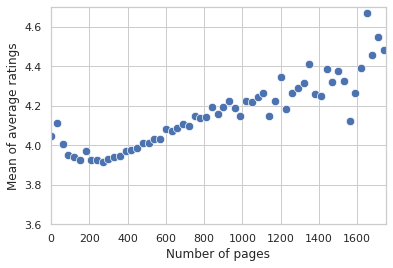

In [227]:
df_ratings_gt1000 = df[df.num_ratings >1000]
df_pages_rating = df.groupby((df_ratings_gt1000['num_pages']//30)*30)['avg_rating'].agg(['mean']).reset_index()
df_pages_rating.columns = ['pages', 'mean_rating']

sns.scatterplot(data=df_pages_rating,x="pages",y="mean_rating",s=70)
plt.xlabel("Number of pages")
plt.ylabel("Mean of average ratings")
plt.xlim(0,1750)
plt.ylim(3.6,4.7);

## Number of reviews vs average rating <a name="num-reviews-vs-rating"></a>

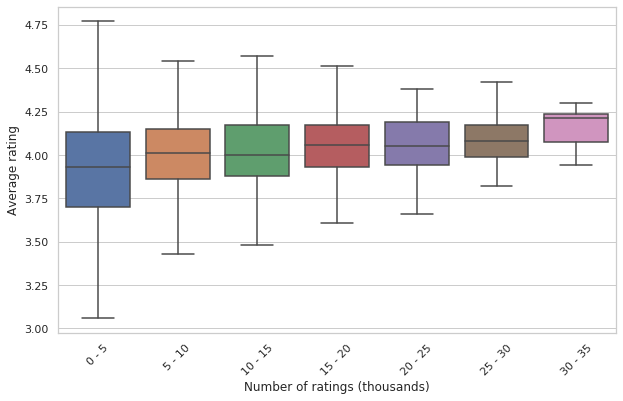

In [273]:
bin_step = 5000
bins = range(0, 40000,bin_step)

df['ratings_bins'] = pd.cut(df['num_reviews'], bins=bins)

plt.figure(figsize=(10, 6))
sns.boxplot(x='ratings_bins', y='avg_rating', data=df, showfliers=False)
custom_labels = [f"{int(start/1000)} - {int((start + bin_step)/1000)}" for start in bins]
plt.xticks(range(len(custom_labels))[:-1], custom_labels[:-1], rotation=45)
plt.xlabel("Number of ratings (thousands)")
plt.ylabel("Average rating");

We find that generally books with more ratings tend to be rated slightly higher

# Conclusions <a name="conclusions"></a>

In this project, we have cleaned and analysed a dataset containing over 100,000 books from Goodreads. By investigating various parameters such as average ratings, page counts and publication dates we have found some interesting relationships. In particular: 

- The average ratings are highest for books published in 1940s and 1950s with a steady decline before/after this era.

- The average number of ratings per book also peaks in the 1940s and 1950s which raise interesting questions about the impact of wider events on literature. 

- We investigated individual authors and showed that the most popular authors (highest number of ratings) are not the same as the highest rated authors. 

- We show that the average rating is positively correlated with both the number of pages and the number of reviews

